In [1]:
!pip install pandas==2.3.3
!pip install wfdb

!pip install neurokit2
import pandas as pd
import numpy as np
import wfdb
import ast
from google.colab import drive

# Mount Google Drive
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = 'ptb-xl-100hz.zip'
extraction_dir = 'ptb-xl-100hz'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_dir)

print(f"Files extracted to {extraction_dir}")



Files extracted to ptb-xl-100hz


# Data Loading and Preprocessing

In [53]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

# Update the path to your Google Drive
path = 'ptb-xl-100hz/ptb-xl-100hz/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) # takes all scp statements in the file



agg_df = agg_df[agg_df.rhythm == 1] # filters them to only include diagnostic statements

"""
def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))"""

def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        #print(key)
        if key in agg_df.index:
            #print(agg_df.loc[key][0])
            tmp.append(key)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
valid_fold = 9


# Train
X_train = X[np.where(Y.strat_fold <valid_fold)]
y_train = Y[(Y.strat_fold <valid_fold)].diagnostic_superclass

# Validation
X_valid = X[np.where(Y.strat_fold == valid_fold)]
y_valid = Y[(Y.strat_fold == valid_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


del X
del Y




In [62]:
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) # takes all scp statements in the file

agg_df = agg_df[agg_df.rhythm == 1] # filters them to only include diagnostic statements

print(agg_df.index)

def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        #print(key)
        if key in agg_df.index:
            #print(agg_df.loc[key][0])
            tmp.append(key)
    return list(set(tmp))


Y['rhythm_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
print([i for i in Y.rhythm_superclass].count('SR'))



print(Y.rhythm_superclass)



Index(['SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR', 'BIGU',
       'AFLT', 'SVTAC', 'PSVT', 'TRIGU'],
      dtype='object')


NameError: name 'Y' is not defined

In [56]:
import numpy
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
import neurokit2 as nk



def create_dataset(data, labels, lead):

  """
  Data formatted as [R, S, L]
  R: record
  S: number of samples or sample index / features
  L: lead

  Each record has 1000 samples (as its 100hz recording over 10 seconds so 100*10)
  Each sample in the record has data for each lead.

  """

  inv_labels_map = {
      0: 'SR',
      1: 'AFIB',
      2: 'STACH',
      3: 'SARRH',
      4: 'SBRAD',
      5: 'PACE',
      6: 'SVARR',
      7: 'BIGU',
      8: 'AFLT',
      9: 'SVTAC',
      10: 'PSVT',
      11: 'TRIGU',
  }

  labels_map = {v:k for k,v in inv_labels_map.items()}

  final_labels = []
  final_data = []
  removed = []



  for i, item in enumerate(labels.values):
    if item:
      final_labels.append(labels_map[item[0]])
      final_data.append(nk.ecg_clean(data[i,:,lead],100))
      #final_data.append(data[i,:,lead]) # For each record store it as all the samples over 1 lead. Should be reformatted as [R, S]

    else:
      removed.append(i)

  return removed, TensorDataset(torch.Tensor(np.array(final_data)), torch.LongTensor(final_labels))


leads = ['I', 'II', 'III', 'aVR' , 'aVL','aVF','V1','V2','V3','V4','V5','V6']




# for multilabel maybe do embeddings
#weight classes with the crossentropyloss torch func

In [58]:

lead_num = 1 # lead 2

train_removed, train_dataset = create_dataset(X_train, y_train, lead_num)

valid_removed, valid_dataset = create_dataset(X_valid, y_valid, lead_num)

test_removed, test_dataset = create_dataset(X_test, y_test, lead_num)

# Datasets in format [R,S]

batch_size = 50
torch.manual_seed(1)

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

# This splits data into [B, Rb, S] for X data and [B, Rb, L] for y data where B = number of batches, Rb = records in batch 50 until final batch  and L = label
# for the case of train_dl X = [342, Rb, 1000] Rb is 50 for all but the last entry where it is 34

counts_train = torch.unique(valid_dataset.tensors[1], return_counts=True)[1]
total_train = sum(counts_train)



weighting = torch.Tensor([i/total_train for i in counts_train])

In [101]:
inv_labels_map = {
      0: 'SR',
      1: 'AFIB',
      2: 'STACH',
      3: 'SARRH',
      4: 'SBRAD',
      5: 'PACE',
      6: 'SVARR',
      7: 'BIGU',
      8: 'AFLT',
      9: 'SVTAC',
      10: 'PSVT',
      11: 'TRIGU',
  }

sum = 0

for i in range(len(inv_labels_map)):

  print(f"{inv_labels_map[i]}, {(list(train_dataset[:][1]) + list(valid_dataset[:][1]) + list(test_dataset[:][1])).count(i)}")

  sum += (list(train_dataset[:][1]) + list(valid_dataset[:][1]) + list(test_dataset[:][1])).count(i)

print(sum)
print(len(valid_dataset))


SR, 16690
AFIB, 1514
STACH, 826
SARRH, 772
SBRAD, 631
PACE, 285
SVARR, 156
BIGU, 62
AFLT, 41
SVTAC, 26
PSVT, 11
TRIGU, 16
21030
2100


# Model Code

In [ ]:
import torch.nn as nn

class ConvNet(nn.Module):

    def __init__(self, conv_kernel, padding, drop_p, pool_size):


        super().__init__()

        self.conv1 = nn.Conv1d(1, 16, 5, padding=padding) #16 filters- should have input [1000,1]
        self.conv2 = nn.Conv1d(16, 32, 9, padding=padding) # 16 filters
        self.conv3 = nn.Conv1d(32, 48, 10, padding=padding) # 16 filters prev had only 2 layers, added 2 more with improved results
        self.conv4 = nn.Conv1d(48, 64, 15, padding=padding) # 16 filters
        self.conv5 = nn.Conv1d(64, 128, 20, padding=padding) # 64 filters
        self.conv6 = nn.Conv1d(128, 256, 27, padding=padding) # 128 filters



        self.max_pool = nn.MaxPool1d(kernel_size = pool_size)
        self.fc1 = nn.Linear(3840, 2000)
        self.fc2 = nn.Linear(2000, 1000) # usually would have softmax function but its already included in the lossfn
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 250)
        self.fc5 = nn.Linear(250, 5)
        self.dropout = nn.Dropout(p=drop_p)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.unsqueeze(1) # [1000,1]
        x = self.relu(self.conv1(x))  # [1000,16]
        x = self.max_pool(x) # [500, 16] floor((1000 - (2-1)-1)/2)+1 = floor(998/2) +1 = 499 +1 = 500

        x = self.relu(self.conv2(x)) # [500, 32]
        x = self.max_pool(x) # [250, 32] floor((500 - (2-1)-1)/2)+1 = floor(498/2) +1 = 249 +1 = 250

        x = self.relu(self.conv3(x))
        x = self.max_pool(x) # [125, 48] floor((250 - (2-1)-1)/2)+1 = floor(248/2) +1 = 124 +1 = 125

        x = self.relu(self.conv4(x))
        x = self.max_pool(x) # [62, 64] floor((125 - 2)/2) + 1 = 61 + 1 = 62

        x = self.relu(self.conv5(x))
        x = self.max_pool(x) # [31, 128] floor((62 - 2)/2) + 1 = 30 + 1 = 31

        x = self.relu(self.conv6(x))
        x = self.max_pool(x) # [15, 256] floor((31 - 2)/2) + 1 = 14 + 1 = 15

        x = self.flatten(x) # [15*256] = [3840]

        x = self.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.relu(self.fc2(x))

        x = self.dropout(x)

        x = self.relu(self.fc3(x))

        x = self.dropout(x)


        x = self.relu(self.fc4(x))


        return self.fc5(x)

"""
class ConvNet(nn.Module):

    def __init__(self, conv_kernel, padding, drop_p, pool_size):



        super().__init__()

        self.conv1 = nn.Conv1d(1, 64, 27, padding=padding) #64 filters- should have input [1000,1]
        self.conv2 = nn.Conv1d(64, 128, 24, padding=padding) # 64 filters
        self.conv3 = nn.Conv1d(128, 192, 15, padding=padding) # 64 filters
        self.conv4 = nn.Conv1d(192, 224, 10, padding=padding) # 32 filters



        self.max_pool = nn.MaxPool1d(kernel_size = pool_size)
        self.fc1 = nn.Linear(13888, 2000)
        self.fc2 = nn.Linear(2000, 500) # usually would have softmax function but its already included in the lossfn
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 5)
        self.dropout = nn.Dropout(p=drop_p)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.unsqueeze(1) # [1000,1]
        x = self.relu(self.conv1(x))  # [1000,64]
        x = self.max_pool(x) # [500, 64] floor((1000 - (2-1)-1)/2)+1 = floor(998/2) +1 = 499 +1 = 500

        x = self.relu(self.conv2(x)) # [500, 128]
        x = self.max_pool(x) # [250, 128] floor((500 - (2-1)-1)/2)+1 = floor(498/2) +1 = 249 +1 = 250

        x = self.relu(self.conv3(x))
        x = self.max_pool(x) # [125, 192] floor((250 - (2-1)-1)/2)+1 = floor(248/2) +1 = 124 +1 = 125

        x = self.relu(self.conv4(x))
        x = self.max_pool(x) # [62, 224] floor((125 - 2)/2) + 1 = 61 + 1 = 62


        x = self.flatten(x) # [62*224] = [13888]

        x = self.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.relu(self.fc2(x))

        x = self.dropout(x)

        x = self.relu(self.fc3(x))

        x = self.dropout(x)


        return self.fc4(x)


"""

'\nclass ConvNet(nn.Module):\n\n    def __init__(self, conv_kernel, padding, drop_p, pool_size):\n\n\n\n        super().__init__()\n\n        self.conv1 = nn.Conv1d(1, 64, 27, padding=padding) #64 filters- should have input [1000,1]\n        self.conv2 = nn.Conv1d(64, 128, 24, padding=padding) # 64 filters\n        self.conv3 = nn.Conv1d(128, 192, 15, padding=padding) # 64 filters\n        self.conv4 = nn.Conv1d(192, 224, 10, padding=padding) # 32 filters\n\n\n\n        self.max_pool = nn.MaxPool1d(kernel_size = pool_size)\n        self.fc1 = nn.Linear(13888, 2000)\n        self.fc2 = nn.Linear(2000, 500) # usually would have softmax function but its already included in the lossfn\n        self.fc3 = nn.Linear(500, 250)\n        self.fc4 = nn.Linear(250, 5)\n        self.dropout = nn.Dropout(p=drop_p)\n        self.relu = nn.ReLU()\n        self.flatten = nn.Flatten()\n\n    def forward(self, x):\n        x = x.unsqueeze(1) # [1000,1]\n        x = self.relu(self.conv1(x))  # [1000,64]\

# Model Training Function

In [ ]:


def train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=None, lam=0.01, num_epochs=50):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)#.squeeze()

            loss = loss_fn(pred, y_batch)


            # Apply L1 regularization
            if regularisation_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lam * l1_norm

            # Apply L2 regularization
            elif regularisation_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lam * l2_norm


            loss.backward() # compute gradient based on results of all predictions made by the model given the inputs, in this case the batches

            optimiser.step()

            optimiser.zero_grad() # resets gradient

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)


        print(f'Epoch {epoch} Train_loss = {loss_hist_train[epoch]}, Valid_loss = {loss_hist_valid[epoch]}')

    return loss_hist_train, loss_hist_valid





# Model wrapper function

In [ ]:

def estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate, num_epochs=20):

  torch.manual_seed(1)

  train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

  model = nn.DataParallel(ConvNet(kernel_size, padding, drop_p, pool_size))
  model = model.to('cuda')

  loss_fn = nn.CrossEntropyLoss(weight=weighting.to('cuda'))

  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  loss_hist_train, loss_hist_valid = train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type='L2', num_epochs=num_epochs, lam=0.0005)

  return model, loss_hist_valid[-1], loss_hist_train, loss_hist_valid


# Grid Search

In [ ]:
import itertools
from sklearn import metrics

parameter_grid = {
    'batch_size': [32, 64, 128],
    'kernel_size': [5, 9, 13],
    'pool_size': [2, 3],
    'padding': [2, 4, 6],
    'drop_p': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
}

def grid_search(estimator, parameter_grid):

  best_val_loss = float('inf')
  best_params = {}

  best_losses = [] #0 is train 1 is valid

  best_f1 = 0

  keys = parameter_grid.keys()



  if torch.cuda.is_available():
      print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
  else:
      print("No GPU available. Training will run on CPU.")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for values in itertools.product(*parameter_grid.values()):
      current_params = dict(zip(keys, values))

      batch_size = current_params['batch_size']
      kernel_size = current_params['kernel_size']
      pool_size = current_params['pool_size']
      padding = current_params['padding']
      drop_p = current_params['drop_p']
      learning_rate = current_params['learning_rate']

      print(f"Testing parameters: {current_params}")

      model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate)

      print(f"Validation Loss: {current_val_loss}")

      pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()
      pred_val_values = np.argmax(pred_val,axis=1)

      f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')

      print(f"Validation f1: {f1_score_val}")

      plot_loss_history(loss_hist_train, loss_hist_valid)

      if current_val_loss < best_val_loss:
          best_val_loss = current_val_loss
          best_params = current_params
          best_f1 = f1_score_val
          best_losses = [loss_hist_train, loss_hist_valid]

  print(f"\nBest validation loss: {best_val_loss}")
  print(f"Best parameters: {best_params}")

  return best_params



# Model Training

GPU: Tesla T4 is available.
cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(


Epoch 0 Train_loss = 0.9211936423913066, Valid_loss = 0.6993333031280177
Epoch 1 Train_loss = 0.7408901942303799, Valid_loss = 0.6604311691192634
Epoch 2 Train_loss = 0.7204947431845007, Valid_loss = 0.6770356328045222
Epoch 3 Train_loss = 0.7072307130012655, Valid_loss = 0.6599101620307062
Epoch 4 Train_loss = 0.7051699628904758, Valid_loss = 0.6505731049810518
Epoch 5 Train_loss = 0.6964014878012876, Valid_loss = 0.645940356574543
Epoch 6 Train_loss = 0.684129152385057, Valid_loss = 0.6668330742617355
Epoch 7 Train_loss = 0.6864465541371806, Valid_loss = 0.6550065798950551
Epoch 8 Train_loss = 0.6782749512663939, Valid_loss = 0.6389208828469691
Epoch 9 Train_loss = 0.6710327311607134, Valid_loss = 0.6468301796964531
Epoch 10 Train_loss = 0.6730276000594624, Valid_loss = 0.652979450229163
Epoch 11 Train_loss = 0.6712027835332379, Valid_loss = 0.6539091472856818
Epoch 12 Train_loss = 0.6713632278142615, Valid_loss = 0.6376471294008563
Epoch 13 Train_loss = 0.6684108417672202, Valid_los

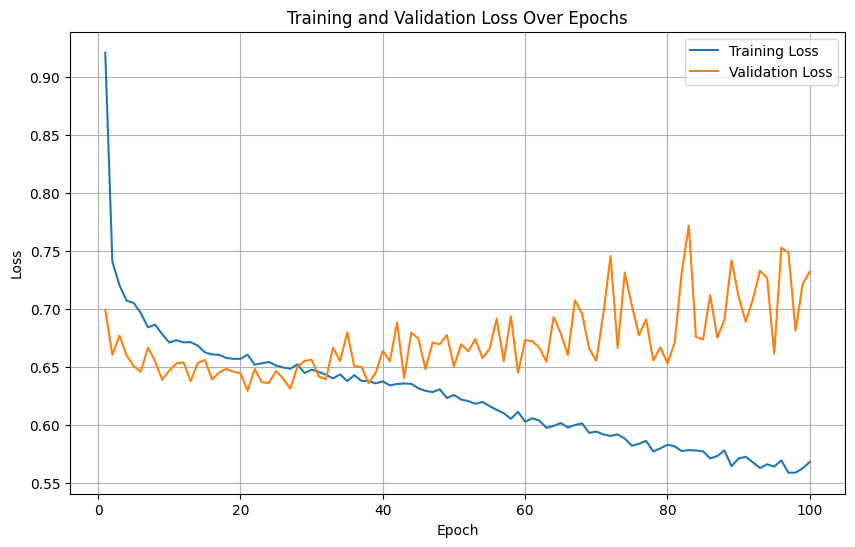

tensor([0, 0, 0,  ..., 0, 4, 0])


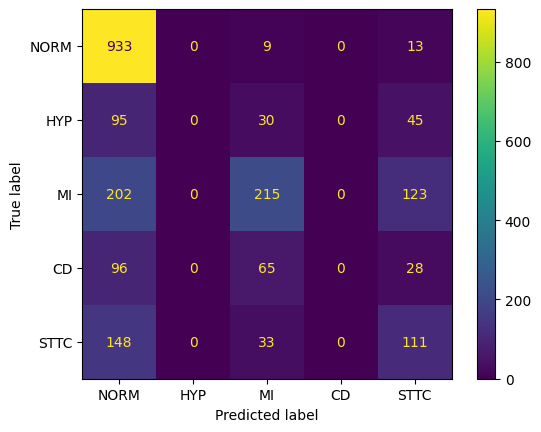

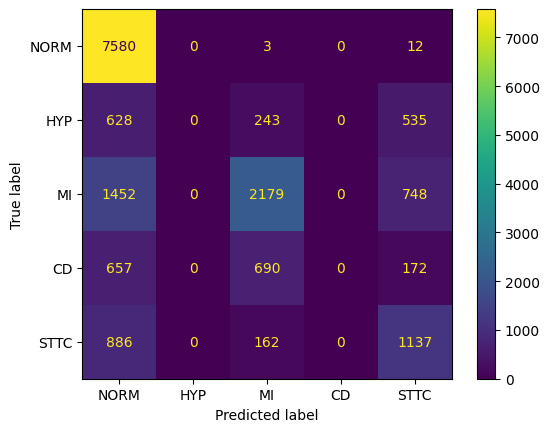

In [ ]:
from sklearn import metrics


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

current_params = {'batch_size': 32, 'kernel_size': 9, 'pool_size': 2, 'padding': 'same', 'drop_p': 0.2, 'learning_rate': 0.0005}

batch_size = current_params['batch_size']
kernel_size = current_params['kernel_size']
pool_size = current_params['pool_size']
padding = current_params['padding']
drop_p = current_params['drop_p']
learning_rate = current_params['learning_rate']

labels = ['NORM', 'HYP', 'MI', 'CD', 'STTC']

model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate, num_epochs=100)

print(f"Validation Loss: {current_val_loss}")



# Model Evaluation Metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_history(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_loss_history(loss_hist_train, loss_hist_valid)

pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()

pred_val_values = np.argmax(pred_val,axis=1)


f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')


pred_train = torch.Tensor.cpu(model(train_dataset.tensors[0])).detach().numpy()

pred_train_values = np.argmax(pred_train,axis=1)
print(train_dataset.tensors[1])

f1_score_train = metrics.f1_score(train_dataset.tensors[1],pred_train_values, average='macro')

matrix_val = metrics.confusion_matrix(valid_dataset.tensors[1], pred_val_values, labels=[0,1,2,3,4])

disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=labels)
disp_val.plot()


matrix_train = metrics.confusion_matrix(train_dataset.tensors[1], pred_train_values, labels=[0,1,2,3,4])

disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=labels)
disp_train.plot()

print(f1_score_val, f1_score_train)

0.32260505034259346 0.3701067388686175
